# Weather Exploration Notebook

In [1]:
import pandas as pd
import numpy as np

import os.path
import requests
import io

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.ensemble import GradientBoostingClassifier

import wrangle
import model
from preprocessing import main_modeling_prep

In [2]:
weather_data = pd.read_csv("US_WeatherEvents_2016-2019.csv")

In [3]:
weather_data[weather_data.State == "NC"].City.unique()

array(['Davis', 'Sanford', 'Goldsboro', 'Salisbury', 'Greensboro',
       'Southport', 'Louisburg', 'Oxford', 'Stoneville', 'Elm City',
       'Smithfield', 'Statesville', 'Franklin', 'Concord', 'Monroe',
       'Richlands', 'Rockingham', 'Whiteville', 'Pope Army Airfield',
       'Washington', 'Erwin', 'Pikeville', 'Tarboro', 'Wilmington',
       'New London', 'Morrisville', 'Mount Airy', 'Jefferson',
       'Engelhard', 'Frisco', 'Andrews', 'Elizabeth City', 'New Bern',
       'Winston Salem', 'Lexington', 'Elizabethtown', 'Iron Station',
       'Rutherfordton', 'Aulander', 'Asheboro', 'Timberlake',
       'Burlington', 'Maxton', 'Wadesboro', 'North Wilkesboro', 'Hoffman',
       'Jacksonville', 'Carthage', 'Edenton', 'Kinston', 'Lumberton',
       'Clinton', 'Fayetteville', 'Manteo', 'Newport', 'Halifax',
       'Kenansville', 'Beaufort', 'Havelock', 'Cleveland', 'Gastonia',
       'Morganton', 'Greenville', 'Maple', 'New River', 'Fletcher',
       'Township 2 Berryhill', 'Kill Devi

In [4]:
weather_data[weather_data.City == "Dallas"]

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
788917,W-789030,Rain,Light,2016-01-06 15:53:00,2016-01-06 16:53:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788918,W-789031,Rain,Light,2016-01-07 01:39:00,2016-01-07 02:00:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788919,W-789032,Rain,Light,2016-01-07 02:18:00,2016-01-07 02:41:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788920,W-789033,Rain,Heavy,2016-01-07 02:41:00,2016-01-07 03:06:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
788921,W-789034,Rain,Moderate,2016-01-07 03:06:00,2016-01-07 04:26:00,US/Central,KRBD,32.6809,-96.8682,Dallas,Dallas,TX,75237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805626,W-3806127,Rain,Light,2019-12-29 18:15:00,2019-12-29 18:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805627,W-3806128,Rain,Light,2019-12-29 20:35:00,2019-12-29 20:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805628,W-3806129,Rain,Light,2019-12-29 22:15:00,2019-12-29 22:55:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0
3805629,W-3806130,Rain,Light,2019-12-30 01:55:00,2019-12-30 02:35:00,US/Eastern,KPUJ,33.9120,-84.9410,Dallas,Paulding,GA,30157.0


In [5]:
# we only want data for 2018

In [6]:
# we only wand data for the following cities

top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

In [7]:
airport_codes = pd.read_csv("https://storage.googleapis.com/kagglesdsdata/datasets%2F626214%2F1116273%2Fairports.csv?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1594952131&Signature=CbuLdZR%2B9YkSTVhPslvV67WILvcTGa1EnhtSpZza10YkL2ccV6HIZLkikKrkF%2BEgwFySBM88hZ4Gp9aqZqA5s5BC%2FL7l71dpdyM8PkBWxtmvJkEYuPYxPvzwt2M10q7T4TzK1mFzUUwPz1CtvLcBdx%2F3GJgd5z4nSGepU3SkoalQHJ4JUQ0SpE5liZiCJ2SB%2FTA4fcz62TvAKv21Jwe7oq4q8CnrG6rvSjW5uRDkvKXDc1sXH2WG2CIZYyt%2FKz2B%2BJsi2iZ9AS9dAhbLO8GVOP6EhtIA9%2ForRmxuBStdXY%2BY1lojJaekb9agtbNS5wAIr%2Fkk0LUHmKPxt7b6jTiLtQ%3D%3D")

In [8]:
airport_codes = airport_codes[airport_codes.Country == "United States"]

In [44]:
airport_codes.head()

,Name,City,Country,IATA,ICAO,Latitude,Longitude
3212,Barter Island LRRS Airport,Barter Island,United States,BTI,PABA,70.134003,-143.582001
3213,Wainwright Air Station,Fort Wainwright,United States,\N,PAWT,70.613403,-159.860001
3214,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,PALU,68.875099,-166.110001
3215,Point Lay LRRS Airport,Point Lay,United States,PIZ,PPIZ,69.732903,-163.005005
3216,Hilo International Airport,Hilo,United States,ITO,PHTO,19.721399,-155.048004


In [9]:
# airport_codes.to_csv("airport_codes.csv")

In [10]:
weather_data = weather_data.merge(airport_codes, how="left", left_on="AirportCode", right_on="ICAO")

In [11]:
top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

for i in top_airports:
    weather_data.loc[weather_data['IATA'] == i, 'is_top'] = True 
    
weather_data.is_top = weather_data.is_top.fillna(False)

In [12]:
weather_data = weather_data[weather_data.is_top]

In [13]:
weather_data["StartTime(UTC)"] = pd.to_datetime(weather_data["StartTime(UTC)"])

In [14]:
weather_data = weather_data.set_index("StartTime(UTC)")

In [15]:
weather_data = weather_data["2018"]

In [16]:
weather_data.sort_values("City_y")

,EventId,Type,Severity,EndTime(UTC),TimeZone,AirportCode,LocationLat,LocationLng,City_x,County,State,ZipCode,Name,City_y,Country,IATA,ICAO,Latitude,Longitude,is_top
StartTime(UTC),,,,,,,,,,,,,,,,,,,,
2018-12-01 17:58:00,W-3204675,Rain,Light,2018-12-01 18:13:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,GA,30320.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-09 20:52:00,W-3204531,Rain,Light,2018-09-09 21:18:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,GA,30320.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-10 19:05:00,W-3204532,Rain,Light,2018-09-10 19:14:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,GA,30320.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-11 20:12:00,W-3204533,Rain,Light,2018-09-11 20:52:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,GA,30320.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
2018-09-11 20:57:00,W-3204534,Rain,Light,2018-09-11 21:52:00,US/Eastern,KATL,33.6301,-84.4418,Atlanta,Clayton,GA,30320.0,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.636700,-84.428101,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-24 14:12:00,W-3376399,Cold,Severe,2018-06-24 14:46:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,WA,98148.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True
2018-06-24 15:53:00,W-3376400,Fog,Moderate,2018-06-24 17:22:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,WA,98148.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True
2018-06-28 21:53:00,W-3376401,Rain,Light,2018-06-28 22:53:00,US/Pacific,KSEA,47.4447,-122.3144,Seattle,King,WA,98148.0,Seattle Tacoma International Airport,Seattle,United States,SEA,KSEA,47.449001,-122.308998,True


---

In [17]:
weather = pd.DataFrame()
unique_cities = weather_data.City_y.unique()

for city in unique_cities:
    city_data = weather_data[weather_data.City_y == city]
    r = pd.date_range(start=city_data.index.min(), end=city_data.index.max(), freq="H")
    city_data = city_data.reindex(r, copy=True)
    city_data["EndTime(UTC)"] = city_data["EndTime(UTC)"].fillna(method="ffill")
    for i in range(city_data["EndTime(UTC)"].unique().shape[0]):
        date = city_data["EndTime(UTC)"].unique()[i]
        mask = (city_data["EndTime(UTC)"] == date) & (city_data.index >= date)
        city_data["Type"] = city_data["Type"].mask(mask, city_data["Type"].fillna("Clear"))
    mask = city_data.Type != "Clear"
    city_data = city_data.mask(mask, city_data.fillna(method="ffill"))
    city_data = city_data.fillna(method="ffill")  
    
    weather = pd.concat([weather, city_data])

In [18]:
features_to_keep = ["Type", "Severity", "TimeZone", "IATA", "City_y", "State"]

weather = weather[features_to_keep]

weather = weather.sort_values(["City_y", "State"])

weather.rename(columns={"City_y":"city"}, inplace=True)

In [19]:
weather.head()

,Type,Severity,TimeZone,IATA,city,State
2018-01-01 14:52:00,Snow,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 15:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 16:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 17:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA
2018-01-01 18:52:00,Clear,Light,US/Eastern,ATL,Atlanta,GA


In [20]:
# We will now normalize the data by changing all time stamps to :30 minutes, to makes it easier to merge
# with our flights df 

weather.index = weather.index.map(lambda t: t.replace(minute=30))

In [21]:
time_zones = weather.TimeZone.unique()
weather_df = pd.DataFrame()
for zone in time_zones:
    mask = weather.TimeZone == zone
    time_zone_df = weather[mask].tz_localize('utc').tz_convert(zone).tz_localize(None)
    weather_df = pd.concat([weather_df, time_zone_df])
    

In [22]:
weather_df["unique_id"] = weather_df.index.astype(str) + "_" + weather_df.IATA

In [23]:
weather_df = weather_df.reset_index().rename(columns={"index": "date"})

In [24]:
weather_df

,date,Type,Severity,TimeZone,IATA,city,State,unique_id
0,2018-01-01 09:30:00,Snow,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 09:30:00_ATL
1,2018-01-01 10:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 10:30:00_ATL
2,2018-01-01 11:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 11:30:00_ATL
3,2018-01-01 12:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 12:30:00_ATL
4,2018-01-01 13:30:00,Clear,Light,US/Eastern,ATL,Atlanta,GA,2018-01-01 13:30:00_ATL
...,...,...,...,...,...,...,...,...
129666,2018-12-31 07:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 07:30:00_SEA
129667,2018-12-31 08:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 08:30:00_SEA
129668,2018-12-31 09:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 09:30:00_SEA
129669,2018-12-31 10:30:00,Clear,Light,US/Pacific,SEA,Seattle,WA,2018-12-31 10:30:00_SEA


-----

In [25]:
df = wrangle.prep_flight_data()

In [26]:
df["crs_dep_time"] = df['crs_dep_time'].astype(str).apply(lambda x: x.zfill(4))

In [27]:
df["fl_datetime"] = df.fl_date.astype(str) + " " + df.crs_dep_time.astype(str)

In [28]:
df.fl_datetime = pd.to_datetime(df.fl_datetime, format="%Y-%m-%d %H%M")

In [29]:
df = df.set_index("fl_datetime")

In [30]:
df.index = df.index.map(lambda t: t.replace(minute=30))

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2965760 entries, 2018-01-01 15:30:00 to 2018-12-31 13:30:00
Data columns (total 27 columns):
fl_date                object
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           object
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
dtypes: float64(19), int64(

In [32]:
features_to_keep = ["fl_date", "op_carrier", "op_carrier_fl_num", "crs_dep_time", "origin", "dest", "dep_delay", "arr_delay", "weather_delay", "Airline"]

In [33]:
df = df[features_to_keep]

In [34]:
df = df.reset_index()

In [35]:
df

,fl_datetime,fl_date,op_carrier,op_carrier_fl_num,crs_dep_time,origin,dest,dep_delay,arr_delay,weather_delay,Airline
0,2018-01-01 15:30:00,2018-01-01,UA,2429,1517,EWR,DEN,-5.0,-23.0,0.0,United Air Lines Inc.
1,2018-01-01 11:30:00,2018-01-01,UA,2427,1115,LAS,SFO,-8.0,-24.0,0.0,United Air Lines Inc.
2,2018-01-01 06:30:00,2018-01-01,UA,2424,0630,ORD,ALB,20.0,14.0,0.0,United Air Lines Inc.
3,2018-01-01 22:30:00,2018-01-01,UA,2422,2241,ORD,OMA,3.0,-11.0,0.0,United Air Lines Inc.
4,2018-01-01 07:30:00,2018-01-01,UA,2421,0750,IAH,LAS,-3.0,-16.0,0.0,United Air Lines Inc.
...,...,...,...,...,...,...,...,...,...,...,...
2965755,2018-12-31 19:30:00,2018-12-31,AA,1814,1955,DFW,PHL,31.0,9.0,0.0,American Airlines Inc.
2965756,2018-12-31 13:30:00,2018-12-31,AA,1815,1321,CLT,DCA,-1.0,-23.0,0.0,American Airlines Inc.
2965757,2018-12-31 17:30:00,2018-12-31,AA,1816,1751,CLT,DFW,6.0,1.0,0.0,American Airlines Inc.
2965758,2018-12-31 20:30:00,2018-12-31,AA,1817,2015,CLT,MEM,-5.0,11.0,0.0,American Airlines Inc.


In [36]:
df["unique_id"] = df.fl_datetime.astype(str) + "_" + df.origin

In [37]:
df.head()

,fl_datetime,fl_date,op_carrier,op_carrier_fl_num,crs_dep_time,origin,dest,dep_delay,arr_delay,weather_delay,Airline,unique_id
0,2018-01-01 15:30:00,2018-01-01,UA,2429,1517,EWR,DEN,-5.0,-23.0,0.0,United Air Lines Inc.,2018-01-01 15:30:00_EWR
1,2018-01-01 11:30:00,2018-01-01,UA,2427,1115,LAS,SFO,-8.0,-24.0,0.0,United Air Lines Inc.,2018-01-01 11:30:00_LAS
2,2018-01-01 06:30:00,2018-01-01,UA,2424,0630,ORD,ALB,20.0,14.0,0.0,United Air Lines Inc.,2018-01-01 06:30:00_ORD
3,2018-01-01 22:30:00,2018-01-01,UA,2422,2241,ORD,OMA,3.0,-11.0,0.0,United Air Lines Inc.,2018-01-01 22:30:00_ORD
4,2018-01-01 07:30:00,2018-01-01,UA,2421,0750,IAH,LAS,-3.0,-16.0,0.0,United Air Lines Inc.,2018-01-01 07:30:00_IAH


In [38]:
df = df.sort_values(["origin", "fl_datetime", "op_carrier"])

---

In [39]:
test = df.merge(weather_df[["Type", "Severity", "unique_id"]], how="left", right_on="unique_id", left_on="unique_id")

In [40]:
weather_df[weather_df.IATA == "CLT"]

,date,Type,Severity,TimeZone,IATA,city,State,unique_id
8738,2018-01-08 15:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 15:30:00_CLT
8739,2018-01-08 16:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 16:30:00_CLT
8740,2018-01-08 17:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 17:30:00_CLT
8741,2018-01-08 18:30:00,Rain,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 18:30:00_CLT
8742,2018-01-08 19:30:00,Clear,Light,US/Eastern,CLT,Charlotte,NC,2018-01-08 19:30:00_CLT
...,...,...,...,...,...,...,...,...
17304,2018-12-31 13:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 13:30:00_CLT
17305,2018-12-31 14:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 14:30:00_CLT
17306,2018-12-31 15:30:00,Fog,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 15:30:00_CLT
17307,2018-12-31 16:30:00,Clear,Severe,US/Eastern,CLT,Charlotte,NC,2018-12-31 16:30:00_CLT


In [41]:
test.Type = test.Type.fillna("Clear")

In [49]:
test.Severity = test.Severity.fillna("Light")

---

# Exploration

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(data=test,x="Type", y="arr_delay", ci=False)
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")

Interesting - it seems that storms lead to the total highest minutes in delays, followed by rain. Clear skies seems to have the smallest amount of delays - which makes sense.

Text(0.5, 0, 'Type of Weather')

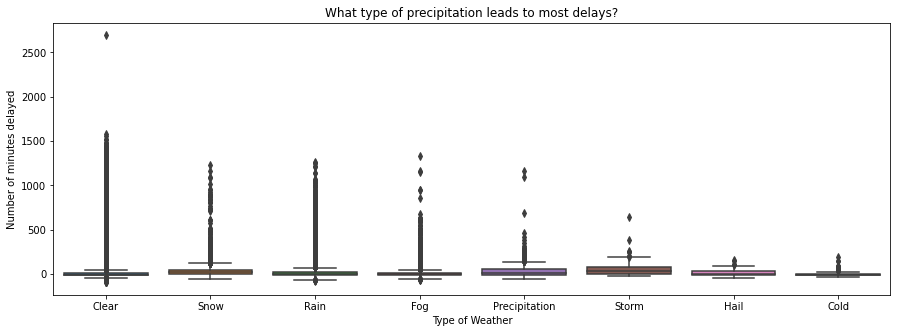

In [55]:
plt.figure(figsize=(15,5))
sns.boxplot(data=test,x="Type", y="arr_delay")
plt.title("What type of precipitation leads to most delays?")
plt.ylabel("Number of minutes delayed")
plt.xlabel("Type of Weather")